[View in Colaboratory](https://colab.research.google.com/github/mogamin/chainer-examples/blob/master/chainer_sign_function_regression.ipynb)

In [0]:
# https://blue1st-tech.hateblo.jp/entry/2017/09/19/012135

In [0]:
!pip install chainer

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

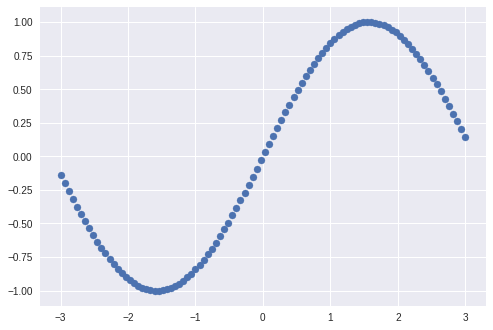

In [134]:
x = np.linspace(-3, 3 ,100)
t = np.sin(x)
plt.scatter(x,t)

In [135]:
import chainer
from chainer.datasets import tuple_dataset
from chainer.datasets import split_dataset_random

x = np.linspace(-3, 3 ,100)
t = np.sin(x)

# ここで、回帰の際に注意しないといけないこととして、教師データのサイズが (xxx,) となっていますが、
# (xxx, 1) のようにxxx行1変数ということを明確にできていないとtrainer.run()のタイミングでエラーが出ます。
# 逆に分類の場合は、(xxx,) のような形式が正しいため、区別して覚えておくことが重要です。

x = x.reshape(len(x), 1)
x = np.array(x, dtype=np.float32)

t = t.reshape(len(t), 1)
t = np.array(t, dtype=np.float32)

dataset = list(zip(x, t))
train, test = split_dataset_random(dataset, int(len(dataset)*0.7))

print(type(train))       #chainer.datasets.sub_dataset.SubDataset
print(type(train[0]))    #tuple
print(type(train[0][0])) #numpy.ndarray
print(type(train[0][1])) #numpy.ndarray

<class 'chainer.datasets.sub_dataset.SubDataset'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
import chainer.links as L
import chainer.functions as F

# モデルの作成
class NN(chainer.Chain):
    # 中間層３層を定義
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1= L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
    
    # 学習用のメソッド
    def __call__(self, x, t, train = True):
      # 与えられたxから推論を行い、その結果と教師データの誤差を返す
      y = self.predictor(x)
      loss = F.mean_squared_error(y, t)
      if train:
          chainer.report({'loss': loss}, self)
      return loss
    
    # 推論
    def predictor(self, x):
      h = F.relu(self.l1(x))
      h = F.relu(self.l2(h))
      return self.l3(h)

In [0]:
# 1層目が100units, 2層目が30units, 3層目が1units(回帰だから)
model = NN(100, 30, 1)

In [0]:
from chainer import optimizers
from chainer import training

optimizer = optimizers.Adam()
optimizer.setup(model)

batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat = False, shuffle = False)
updater = training.StandardUpdater(train_iter, optimizer)

In [139]:
from chainer.training import extensions

epoch = 200
trainer = training.Trainer(updater, (epoch, 'epoch'), out = 'result')
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           1.12555     0.320404              0.0153993     
2           0.456463    0.162036              0.0265117     
3           0.204963    0.248079              0.0398844     
4           0.157637    0.382189              0.0504552     
5           0.238593    0.475454              0.0630057     
6           0.23753     0.434726              0.0735003     
7           0.207309    0.348458              0.0863736     
8           0.162421    0.274877              0.0974663     
9           0.149063    0.210832              0.112699      
10          0.152597    0.187269              0.123851      
11          0.159976    0.174395              0.136772      
12          0.153099    0.175818              0.14698       
13          0.146581    0.188782              0.160335      
14          0.151209    0.211135              0.170781      
15          0.147408    0.232693              0.184869      
16          0.138956    0.

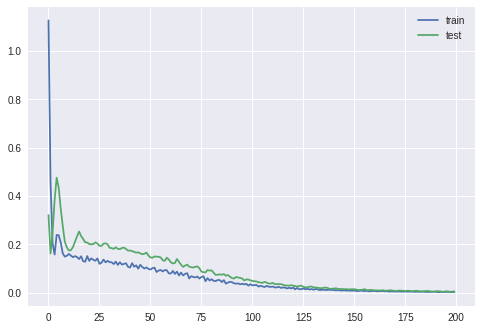

In [140]:
import json

with open('result/log') as f:
    logs = json.load(f)

result_train = [log['main/loss'] for log in logs]
result_test = [log['validation/main/loss'] for log in logs]

plt.plot(result_train, label = 'train')
plt.plot(result_test, label = 'test')
plt.legend()
plt.show()

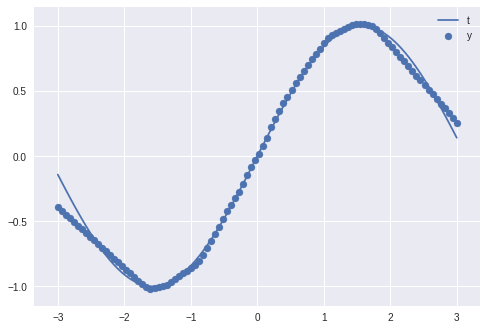

In [141]:
# モデルを使用した予測値
y = model.predictor(x).data
plt.plot(x, t, label = 't')
plt.scatter(x, y, label = 'y')
plt.legend()
plt.show()